# Selection of the best local area to implement a potato crop

### Importar librerías

In [1]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx
from pathlib import Path
import numpy as np
import fiona
from shapely.geometry import Point
from shapely.ops import unary_union

## Data preparation & CRS
Se define la ruta ruta principal en donde reposan los 5 archivos a trabajar:
* municipios_colombia.shp
* Evaluaciones_Agropecuarias_Municipales_EVA.csv
* Catalogo_Estaciones_IDEAM.csv
* CBasica.gbd (vías)
* BOYACA_CAPACIDAD_VF.shp

Para los archivos .csv se emplea **utf-8** como sistema para la lectura

In [2]:
root_folder = r"C:\Users\sanac\Documents\UN\Programacion_SIG\Archivos"
shp_path = root_folder+"/municipios_colombia.shp"
csv_path = root_folder+"/Evaluaciones_Agropecuarias_Municipales_EVA.csv"
stations_csv_path = root_folder+"/Catalogo_Estaciones_IDEAM.csv"
road_path = root_folder+"/CBasica.gdb"
uso_path = root_folder+"/BOYACA_CAPACIDAD_VF.shp"
muni = gpd.read_file(shp_path)
uso = gpd.read_file(uso_path)
eva = pd.read_csv(csv_path, encoding ='utf-8')
estac = pd.read_csv(stations_csv_path, encoding ='utf-8')

Debido a que el archivo Cbasica es una gbd, es necesario conocer los archivos que integran esa base, por lo que se emplea **fiona.listlayers()**

In [3]:
print(fiona.listlayers(road_path))

['Via', 'Puente_L', 'Puente_P', 'Tunel', 'VFerre', 'LVia', 'SVial', 'T_1_DirtyAreas', 'T_1_PointErrors', 'T_1_LineErrors', 'T_1_PolyErrors']


In [4]:
roads = gpd.read_file(road_path, layer="Via")

Se realiza una exploración de los atributos que conforman **Via** y se realiza la proyección a EPSG 9377

In [5]:
print(roads.columns)
print(roads.head())
print(roads["VTipo"].unique())
roads = roads.to_crs(epsg=9377)
print("CRS muni:", roads.crs)

Index(['VIdentifi', 'VTipo', 'VEstado', 'VCarril', 'VAcceso', 'SHAPE_Length',
       'RuleID', 'Override', 'geometry'],
      dtype='object')
  VIdentifi  VTipo VEstado VCarril VAcceso  SHAPE_Length  RuleID Override  \
0      None      1    3301    3501       1  12653.163260       1     None   
1      None      1    3301    3501       1    299.705614       1     None   
2      None      1    3301    3501       1  40043.323887       1     None   
3      None      1    3301    3501       1   1243.421210       1     None   
4      None      1    3301    3501       1  12354.058156       1     None   

                                            geometry  
0  MULTILINESTRING ((4931953.929 2019745.827, 493...  
1  MULTILINESTRING ((4973542.236 1968082.723, 497...  
2  MULTILINESTRING ((4931410.728 1940091.645, 493...  
3  MULTILINESTRING ((4958931.023 1920359.389, 495...  
4  MULTILINESTRING ((4950963.332 1927874.323, 495...  
[1 2 3 4 5 6 7 8]
CRS muni: EPSG:9377


Se realiza un filtro sobre las vías por medio del tipo de vía para facilitar el procesamiento de la información. Se seleccionan las vías Tipo 1

In [6]:
type1_road = roads[roads['VTipo'] == 1]

Se realiza una visualización de los datos filtrados almacenados en **type1_road**

In [7]:
type1_road.head()

,VIdentifi,VTipo,VEstado,VCarril,VAcceso,SHAPE_Length,RuleID,Override,geometry
0,None,1,3301,3501,1,12653.163260,1,None,"MULTILINESTRING ((4931953.929 2019745.827, 493..."
1,None,1,3301,3501,1,299.705614,1,None,"MULTILINESTRING ((4973542.236 1968082.723, 497..."
2,None,1,3301,3501,1,40043.323887,1,None,"MULTILINESTRING ((4931410.728 1940091.645, 493..."
3,None,1,3301,3501,1,1243.421210,1,None,"MULTILINESTRING ((4958931.023 1920359.389, 495..."
4,None,1,3301,3501,1,12354.058156,1,None,"MULTILINESTRING ((4950963.332 1927874.323, 495..."


Se realiza una proyección de **muni** y **uso** a EPSG 9377

In [8]:
muni = muni.to_crs(epsg=9377)
print("CRS muni:", muni.crs)
uso = uso.to_crs(epsg=9377)
print("CRS uso:", muni.crs)

CRS muni: EPSG:9377
CRS uso: EPSG:9377


Con respecto a **estac**, es necesario realizar la conversión a un GeoDataFrame por medio de `.GeoDataFram`, la cual se almacena en **estac_gpd**. Dentro de `.GeoDataFram` se define el sistema de coordenadas teniendo en cuenta las columnas de Longitud y Latitud que se encuentran dentro del documento

Se realiza la reproyección del archivo de 4326 a 3116 por medio de `.to_crs()`

In [9]:
estac[['Latitud', 'Longitud']] = estac['Ubicación'].apply(lambda x: pd.Series(eval(x)))
estac_gpd = gpd.GeoDataFrame(
    estac,
    geometry = gpd.points_from_xy(estac['Longitud'], estac['Latitud']),
    crs="EPSG:4326"
)
estac_gpd = estac_gpd.to_crs(epsg=9377)
print("CRS estaciones:", estac_gpd.crs)
print(estac_gpd.head())

CRS estaciones: EPSG:9377
     Codigo                          Nombre            Categoria  Estado  \
0  52057100      RUMICHACA - AUT [52057100]         Limnigráfica  Activa   
1  52055170    LA JOSEFINA - AUT [52055170]  Climática Principal  Activa   
2  52055220     EL PARAISO - AUT [52055220]  Climática Principal  Activa   
3  44015070      EL PEPINO - AUT [44015070]  Climática Principal  Activa   
4  48015040  PUERTO NARINO - AUT [48015040]  Climática Principal  Activa   

  Departamento      Municipio                    Ubicación  Altitud  \
0       Nariño        Ipiales   (0.81378611, -77.66197778)     2582   
1       Nariño      Contadero   (0.93030556, -77.49119444)     2450   
2       Nariño      Túquerres   (1.07061111, -77.63688889)     3120   
3     Putumayo          Mocoa   (1.08288889, -76.66711111)      760   
4     Amazonas  Puerto Nariño  (-3.78030556, -70.36263889)      158   

  Fecha_instalacion Fecha_suspension Corriente   Latitud   Longitud  \
0        2016-11-15

Sobre **eva** se realiza un renombramiento de la columna 'CÓD. MUN.' a 'MPIO_CDPMP' por facilidad en la escritura del código por medio de `.rename()`

Se evidencia que dentro de **eva** y **muni**, se encuentran las columnas de los códigos municipales, por tanto, a los dos archivos se les aplica `.astype(str).str.zfill(5)` con el fin de que el tipo de dato sea string con 5 caracteres debido a que esa es la cantidad del código de municipio. Se realiza el mismo procedimiento para los códigos departamentales manteniendo 2 caracteres

In [10]:
eva = eva.rename(columns={'CÓD. MUN.': 'MPIO_CDPMP'})
eva['MPIO_CDPMP'] = eva['MPIO_CDPMP'].astype(str).str.zfill(5)
muni['MPIO_CDPMP'] = muni['MPIO_CDPMP'].astype(str).str.zfill(5)
muni['DPTO_CCDGO'] = muni['DPTO_CCDGO'].astype(str).str.zfill(2)

Se realiza un filtro en **muni** seleccionando sólo los municipios del departamento de Boyacá. Se almacena en **boy_muni** generando una copia por medio de `.copy()`

In [11]:
boy_muni = muni[muni['DPTO_CCDGO'] == '15'].copy()

Se visualizan los atributos de **boy_muni**

In [12]:
boy_muni.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_PRIM,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry
637,15,001,TUNJA,15001,2018,11968.891815,5.518473,-73.378019,79594.0,0.0,...,35470.0,56563.0,43652.0,14337.0,3156.0,4044.0,0.572327,0.009766,15001,"POLYGON ((4959760.536 2172167.311, 4959767.787..."
638,15,022,ALMEIDA,15022,2018,5767.211917,4.954825,-73.388134,2649.0,0.0,...,796.0,514.0,83.0,18.0,88.0,16.0,0.348469,0.004702,15022,"POLYGON ((4959230.781 2111994.725, 4959364.580..."
639,15,047,AQUITANIA,15047,2018,94214.656272,5.437416,-72.871495,25311.0,0.0,...,6536.0,4629.0,669.0,77.0,837.0,106.0,1.800311,0.076844,15047,"POLYGON ((5026299.410 2181056.535, 5026366.975..."
640,15,051,ARCABUCO,15051,2018,13789.858803,5.749565,-73.438880,4414.0,0.0,...,2433.0,1913.0,461.0,66.0,178.0,28.0,0.752709,0.011257,15051,"POLYGON ((4944132.595 2203718.480, 4944172.143..."
641,15,087,BELÉN,15087,2018,16308.822003,6.005059,-72.893699,8167.0,0.0,...,3050.0,2581.0,781.0,103.0,289.0,59.0,0.629349,0.013315,15087,"POLYGON ((5009188.804 2230505.691, 5009166.938..."


## Core analysis steps — Level 1: Municipality selection
El análisis de la selección del municipio para implementar el proyecto productivo comienza por conocer si los municipios del departamento de Boyacá intersecan con las vías Tipo 1, así entonces, se realiza un buffer de 1km sobre **type1_road**

In [13]:
roads1 = type1_road.buffer(1000)

Una vez realizado el buffer, se realiza una instersección con **boy_muni** para conocer el área de las vías Tipo 1 por municipio. Para calcular el área de las vías por municipio se emplea `.area`

In [14]:
boy_muni['Area_via_1km'] = boy_muni.geometry.intersection(roads1.unary_union).area/1e6
boy_muni.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,Area_via_1km
637,15,001,TUNJA,15001,2018,11968.891815,5.518473,-73.378019,79594.0,0.0,...,56563.0,43652.0,14337.0,3156.0,4044.0,0.572327,0.009766,15001,"POLYGON ((4959760.536 2172167.311, 4959767.787...",83.676875
638,15,022,ALMEIDA,15022,2018,5767.211917,4.954825,-73.388134,2649.0,0.0,...,514.0,83.0,18.0,88.0,16.0,0.348469,0.004702,15022,"POLYGON ((4959230.781 2111994.725, 4959364.580...",0.000000
639,15,047,AQUITANIA,15047,2018,94214.656272,5.437416,-72.871495,25311.0,0.0,...,4629.0,669.0,77.0,837.0,106.0,1.800311,0.076844,15047,"POLYGON ((5026299.410 2181056.535, 5026366.975...",69.036334
640,15,051,ARCABUCO,15051,2018,13789.858803,5.749565,-73.438880,4414.0,0.0,...,1913.0,461.0,66.0,178.0,28.0,0.752709,0.011257,15051,"POLYGON ((4944132.595 2203718.480, 4944172.143...",68.302846
641,15,087,BELÉN,15087,2018,16308.822003,6.005059,-72.893699,8167.0,0.0,...,2581.0,781.0,103.0,289.0,59.0,0.629349,0.013315,15087,"POLYGON ((5009188.804 2230505.691, 5009166.938...",49.122116


Se realiza una superposición entre **type1_road** y **boy_muni** por medio de `.overlay` definiendo `intersection`

In [15]:
vias_boy_muni = gpd.overlay(type1_road, boy_muni , how = 'intersection')

Para calcular la longitud de las vías por municipio, se crea un campo **long_via (km)** dentro de **vias_boy_muni** y se emplea `.lenght`. Después se realiza una agrupación por municipio para conocer la totalidad de km2 de vías por municipio, almacenándose en **long_vias**

In [16]:
vias_boy_muni['long_via (km)'] = vias_boy_muni.geometry.length/1000
long_vias = vias_boy_muni.groupby('MPIO_CDPMP')['long_via (km)'].sum().reset_index()
long_vias.head()

,MPIO_CDPMP,long_via (km)
0,15001,64.134771
1,15047,34.318971
2,15051,40.744726
3,15087,32.202651
4,15104,10.221110


Para calcular el área de los municipios de Boyacá, se crea el campo **Area (km2)** y se emplea `.area`

In [17]:
boy_muni['Area (km2)'] = boy_muni.geometry.area / 1e6

Se realiza la unión de la longitud de vías con **boy_muni** por medio de `.merge` con el campo en común MPIO_CDPMP
Se calcula la densidad de vías dividiendo la longitud de las vías entre el total del área de cada municipio

In [18]:
boy_muni = boy_muni.drop(columns=['long_via (km)'], errors = 'ignore')  # Elimina si existe
boy_muni = boy_muni.merge(long_vias, on = 'MPIO_CDPMP', how = 'left')
boy_muni['Densidad_vial'] = boy_muni['long_via (km)'] / boy_muni['Area (km2)']
boy_muni.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,Area_via_1km,Area (km2),long_via (km),Densidad_vial
0,15,001,TUNJA,15001,2018,11968.891815,5.518473,-73.378019,79594.0,0.0,...,3156.0,4044.0,0.572327,0.009766,15001,"POLYGON ((4959760.536 2172167.311, 4959767.787...",83.676875,119.484917,64.134771,0.536760
1,15,022,ALMEIDA,15022,2018,5767.211917,4.954825,-73.388134,2649.0,0.0,...,88.0,16.0,0.348469,0.004702,15022,"POLYGON ((4959230.781 2111994.725, 4959364.580...",0.000000,57.574192,NaN,NaN
2,15,047,AQUITANIA,15047,2018,94214.656272,5.437416,-72.871495,25311.0,0.0,...,837.0,106.0,1.800311,0.076844,15047,"POLYGON ((5026299.410 2181056.535, 5026366.975...",69.036334,940.228755,34.318971,0.036501
3,15,051,ARCABUCO,15051,2018,13789.858803,5.749565,-73.438880,4414.0,0.0,...,178.0,28.0,0.752709,0.011257,15051,"POLYGON ((4944132.595 2203718.480, 4944172.143...",68.302846,137.669042,40.744726,0.295961
4,15,087,BELÉN,15087,2018,16308.822003,6.005059,-72.893699,8167.0,0.0,...,289.0,59.0,0.629349,0.013315,15087,"POLYGON ((5009188.804 2230505.691, 5009166.938...",49.122116,162.758743,32.202651,0.197855


Se realiza la visualización de las vías Tipo 1 en los municipios de Boyacá

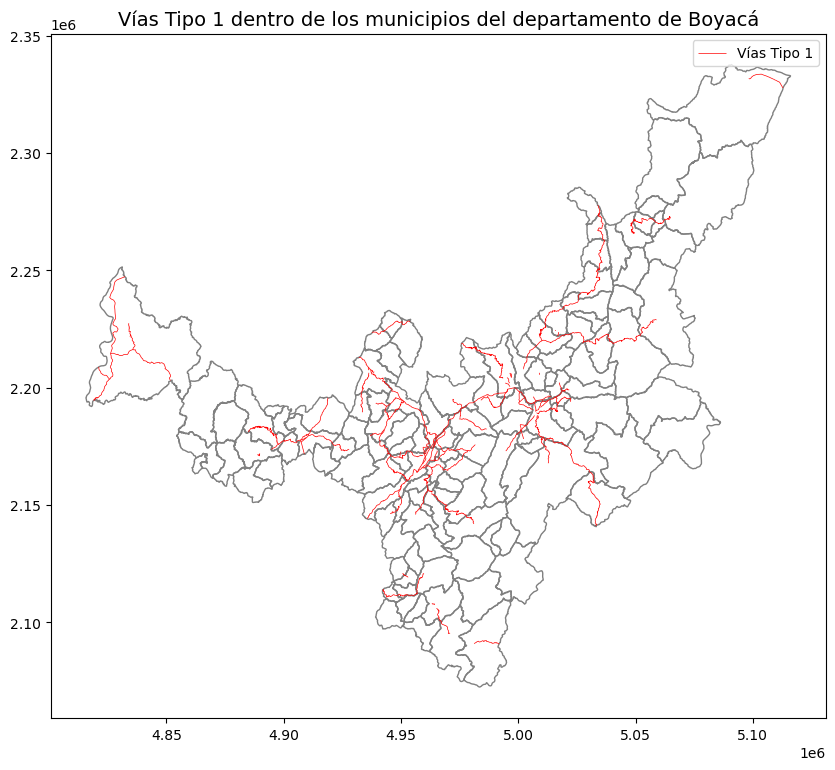

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
boy_muni.plot(ax=ax, facecolor='none', edgecolor='gray')
vias_boy_muni.plot(ax=ax, color='red', linewidth=0.5, label = "Vías Tipo 1")

ax.set_title("Vías Tipo 1 dentro de los municipios del departamento de Boyacá", fontsize=14)
ax.legend()

plt.show()

Se visualizan los 20 primeros municipios con mayor densidad vial

In [20]:
top20 = boy_muni.sort_values(by='Densidad_vial', ascending=False).head(20)
top20.head(20)

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,Area_via_1km,Area (km2),long_via (km),Densidad_vial
114,15,820,TÓPAGA,15820,2018,3362.952821,5.765350,-72.836730,4601.0,0.0,...,115.0,28.0,0.271281,0.002744,15820,"POLYGON ((5019179.796 2198447.775, 5019201.860...",25.056253,33.560325,19.392458,0.577839
0,15,001,TUNJA,15001,2018,11968.891815,5.518473,-73.378019,79594.0,0.0,...,3156.0,4044.0,0.572327,0.009766,15001,"POLYGON ((4959760.536 2172167.311, 4959767.787...",83.676875,119.484917,64.134771,0.536760
70,15,500,OICATÁ,15500,2018,6030.217623,5.610788,-73.279919,3363.0,0.0,...,123.0,19.0,0.337625,0.004921,15500,"POLYGON ((4970775.951 2183588.522, 4970795.111...",25.943113,60.195532,20.572734,0.341765
68,15,491,NOBSA,15491,2018,5542.547563,5.778760,-72.932683,8895.0,0.0,...,267.0,172.0,0.368771,0.004523,15491,"POLYGON ((5005715.918 2199736.758, 5005755.287...",25.351020,55.314895,18.499528,0.334440
102,15,764,SORACÁ,15764,2018,5575.775305,5.494890,-73.319000,4971.0,0.0,...,307.0,28.0,0.351033,0.004549,15764,"POLYGON ((4965278.967 2170513.321, 4965345.451...",32.175859,55.660566,18.540001,0.333090
54,15,322,GUATEQUE,15322,2018,3613.928524,5.014508,-73.488124,8952.0,0.0,...,319.0,101.0,0.287084,0.002947,15322,"POLYGON ((4947137.214 2117064.162, 4947156.364...",16.857538,36.080287,11.220887,0.310998
41,15,224,CUCAITA,15224,2018,4212.806645,5.527104,-73.445986,2762.0,0.0,...,89.0,25.0,0.291959,0.003438,15224,"POLYGON ((4952644.846 2172796.395, 4952658.155...",17.014503,42.058134,12.922440,0.307252
3,15,051,ARCABUCO,15051,2018,13789.858803,5.749565,-73.438880,4414.0,0.0,...,178.0,28.0,0.752709,0.011257,15051,"POLYGON ((4944132.595 2203718.480, 4944172.143...",68.302846,137.669042,40.744726,0.295961
53,15,317,GUACAMAYAS,15317,2018,5765.232987,6.445439,-72.516353,3329.0,0.0,...,86.0,8.0,0.299985,0.004709,15317,"POLYGON ((5050985.752 2274909.694, 5051009.932...",23.150245,57.521732,16.219832,0.281977
34,15,759,SOGAMOSO,15759,2018,20830.587404,5.667956,-72.886303,72814.0,0.0,...,2641.0,2273.0,0.719738,0.016997,15759,"POLYGON ((5013185.582 2195222.630, 5013208.682...",88.369512,207.883934,56.807417,0.273265


Se realiza la visualización por densidad vial de los municipios de Boyacá, resaltando los 20 municipios con mayor cantidad de longitud de vías por área

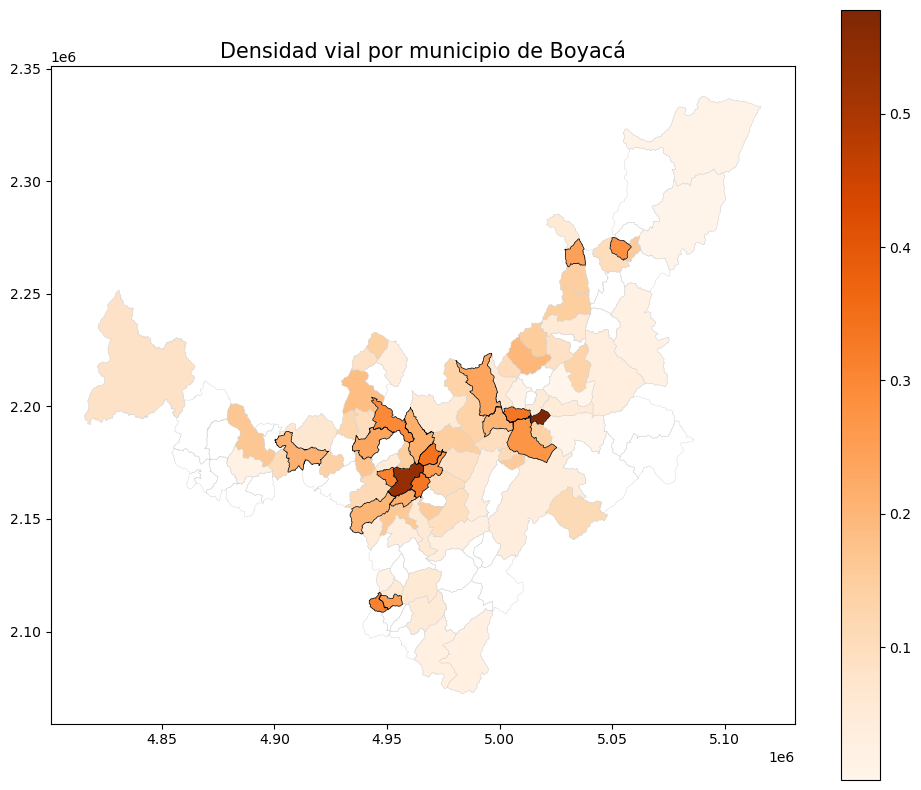

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

boy_muni.plot(ax=ax, facecolor='none', linewidth=0.3, edgecolor='lightgray')
boy_muni.plot(column='Densidad_vial',
               cmap='Oranges',
               linewidth=0.3,
               edgecolor='lightgray',
               legend=True,
               ax=ax)

top20.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

ax.set_title('Densidad vial por municipio de Boyacá', fontsize=15)

plt.show()

Se realiza la unión de las estaciones (**estac_gpd**) y **boy_muni** realizando un conteo por municipio el cual se almacena en **conteo_est**. Se realiza la unión del número de estaciones por municipio en la capa de municipios de Boyacá por medio de `.merge`con el campo en común MPIO_CDPMP

In [22]:
esta_join = gpd.sjoin(estac_gpd, boy_muni, how="left", predicate="within")
conteo_est = esta_join.groupby("MPIO_CDPMP").size().reset_index(name="N_estaciones")

if "N_estaciones" in boy_muni.columns:
    boy_muni = boy_muni.drop(columns=["N_estaciones"])
    
boy_muni = boy_muni.merge(conteo_est, on="MPIO_CDPMP", how="left")
boy_muni["N_estaciones"] = boy_muni["N_estaciones"].fillna(0).astype(int)

boy_muni.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,Area_via_1km,Area (km2),long_via (km),Densidad_vial,N_estaciones
0,15,001,TUNJA,15001,2018,11968.891815,5.518473,-73.378019,79594.0,0.0,...,4044.0,0.572327,0.009766,15001,"POLYGON ((4959760.536 2172167.311, 4959767.787...",83.676875,119.484917,64.134771,0.536760,5
1,15,022,ALMEIDA,15022,2018,5767.211917,4.954825,-73.388134,2649.0,0.0,...,16.0,0.348469,0.004702,15022,"POLYGON ((4959230.781 2111994.725, 4959364.580...",0.000000,57.574192,NaN,NaN,4
2,15,047,AQUITANIA,15047,2018,94214.656272,5.437416,-72.871495,25311.0,0.0,...,106.0,1.800311,0.076844,15047,"POLYGON ((5026299.410 2181056.535, 5026366.975...",69.036334,940.228755,34.318971,0.036501,37
3,15,051,ARCABUCO,15051,2018,13789.858803,5.749565,-73.438880,4414.0,0.0,...,28.0,0.752709,0.011257,15051,"POLYGON ((4944132.595 2203718.480, 4944172.143...",68.302846,137.669042,40.744726,0.295961,2
4,15,087,BELÉN,15087,2018,16308.822003,6.005059,-72.893699,8167.0,0.0,...,59.0,0.629349,0.013315,15087,"POLYGON ((5009188.804 2230505.691, 5009166.938...",49.122116,162.758743,32.202651,0.197855,1


Se visualizan los 20 primeros municipios con mayor número de estaciones

In [23]:
top20_estac = boy_muni.sort_values(by='N_estaciones', ascending=False).head(20)
top20_estac.head(20)

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,Area_via_1km,Area (km2),long_via (km),Densidad_vial,N_estaciones
2,15,047,AQUITANIA,15047,2018,94214.656272,5.437416,-72.871495,25311.0,0.0,...,106.0,1.800311,0.076844,15047,"POLYGON ((5026299.410 2181056.535, 5026366.975...",69.036334,940.228755,34.318971,0.036501,37
85,15,646,SAMACÁ,15646,2018,16758.623680,5.470540,-73.521176,12457.0,0.0,...,140.0,0.663349,0.013674,15646,"POLYGON ((4945379.972 2171633.348, 4945391.557...",28.669564,167.316281,19.063478,0.113937,21
74,15,516,PAIPA,15516,2018,30510.919497,5.826772,-73.137952,24751.0,0.0,...,425.0,1.069622,0.024906,15516,"POLYGON ((4985565.604 2211368.399, 4985529.370...",62.886856,304.541368,41.930874,0.137685,16
93,15,690,SANTA MARÍA,15690,2018,30965.967352,4.823003,-73.253775,3128.0,0.0,...,28.0,1.049963,0.025239,15690,"POLYGON ((4975814.948 2106348.588, 4975853.363...",20.935057,309.106607,7.406692,0.023962,15
83,15,632,SABOYÁ,15632,2018,24865.196199,5.699926,-73.747995,11738.0,0.0,...,155.0,0.792251,0.020298,15632,"POLYGON ((4920938.441 2196916.855, 4920940.440...",35.657261,248.288270,17.101413,0.068877,15
16,15,176,CHIQUINQUIRÁ,15176,2018,16501.366942,5.622488,-73.804245,28678.0,0.0,...,1047.0,0.864128,0.013469,15176,"POLYGON ((4906125.747 2188877.144, 4906143.409...",51.145052,164.778383,34.689230,0.210521,14
34,15,759,SOGAMOSO,15759,2018,20830.587404,5.667956,-72.886303,72814.0,0.0,...,2273.0,0.719738,0.016997,15759,"POLYGON ((5013185.582 2195222.630, 5013208.682...",88.369512,207.883934,56.807417,0.273265,13
45,15,238,DUITAMA,15238,2018,23402.439254,5.890603,-73.067095,63992.0,0.0,...,1994.0,0.959492,0.019105,15238,"POLYGON ((4996377.448 2223526.319, 4996413.641...",88.491707,233.578051,55.659223,0.238290,12
75,15,518,PAJARITO,15518,2018,31368.257433,5.382329,-72.696727,1703.0,0.0,...,19.0,0.855039,0.025579,15518,"POLYGON ((5030360.642 2164253.685, 5030372.000...",56.062215,313.008178,34.743115,0.110997,12
112,15,814,TOCA,15814,2018,16825.186277,5.580254,-73.160697,6963.0,0.0,...,53.0,0.542314,0.013729,15814,"POLYGON ((4980454.631 2180718.366, 4980451.709...",25.980804,167.941200,14.296922,0.085131,12


Se realiza la visualización espacial de la ubicación de las estaciones de los 20 municipios con mayor número de estaciones

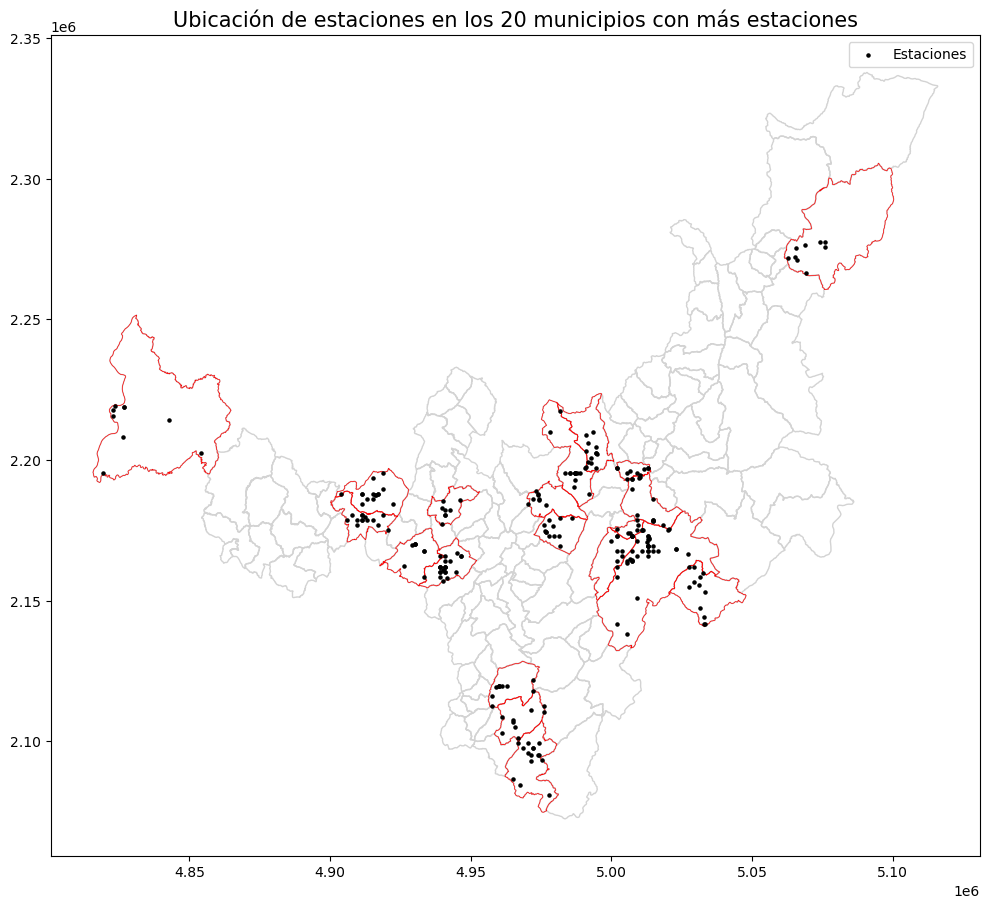

In [24]:
top20_estaciones = gpd.sjoin(estac_gpd, top20_estac, how="inner", predicate="within")

fig, ax = plt.subplots(figsize=(10, 10))
boy_muni.plot(ax=ax, facecolor='none', edgecolor='lightgray')
top20_estac.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=0.5)
top20_estaciones.plot(ax=ax, color="black", markersize=5, label="Estaciones")

ax.set_title("Ubicación de estaciones en los 20 municipios con más estaciones", fontsize=15)
ax.legend()

plt.tight_layout()
plt.show()

Se despliegan los atributos en **eva** por medio de `.columns` y el nombre de los departamentos contenidos en DEPARTAMENTO por medio de `.unique()`

In [25]:
print(eva.columns)
print(eva["DEPARTAMENTO"].unique())

Index(['CÓD. \nDEP.', 'DEPARTAMENTO', 'MPIO_CDPMP', 'MUNICIPIO',
       'GRUPO \nDE CULTIVO', 'SUBGRUPO \nDE CULTIVO', 'CULTIVO',
       'DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO', 'AÑO', 'PERIODO',
       'Área Sembrada\n(ha)', 'Área Cosechada\n(ha)', 'Producción\n(t)',
       'Rendimiento\n(t/ha)', 'ESTADO FISICO PRODUCCION',
       'NOMBRE \nCIENTIFICO', 'CICLO DE CULTIVO'],
      dtype='object')
['BOYACA' 'CUNDINAMARCA' 'NORTE DE SANTANDER' 'SANTANDER' 'CAUCA'
 'VALLE DEL CAUCA' 'CALDAS' 'PUTUMAYO' 'TOLIMA' 'NARIÑO' 'QUINDIO'
 'ANTIOQUIA' 'CAQUETA' 'AMAZONAS' 'CHOCO' 'HUILA' 'ARAUCA' 'CASANARE'
 'LA GUAJIRA' 'BOLIVAR' 'CESAR' 'META' 'RISARALDA' 'SUCRE' 'CORDOBA'
 'VICHADA' 'MAGDALENA' 'GUAINIA' 'ATLANTICO' 'SAN ANDRES Y PROVIDENCIA'
 'GUAVIARE' 'VAUPES']


Se realiza un filtro sobre **eva** definiendo el cultivo de papa en el año 2017 de la información de los municipios de Boyacá. Se calcula el rendimiento por la relación entre Producción\n(t) y Área Sembrada\n(ha). Una vez calculado el rendimiento, se realiza una agrupación de rendimiento, producción y área por municipio

In [26]:
papa_boy = (
    eva.query('CULTIVO == "PAPA" and AÑO == 2017 and DEPARTAMENTO == "BOYACA"')
    .copy()
)
papa_boy['Rendimiento (ton/ha)'] = (papa_boy['Producción\n(t)'] / papa_boy['Área Sembrada\n(ha)'])

papa_agrupado = papa_boy.groupby(['MPIO_CDPMP','MUNICIPIO']).agg({
    'Producción\n(t)': 'sum',
    'Área Sembrada\n(ha)': 'sum',
    'Rendimiento (ton/ha)': 'sum'
}).reset_index()

papa_agrupado.head()

,MPIO_CDPMP,MUNICIPIO,Producción\n(t),Área Sembrada\n(ha),Rendimiento (ton/ha)
0,15001,TUNJA,77600,3975,60.000000
1,15022,ALMEIDA,46,9,9.900000
2,15047,AQUITANIA,8831,425,58.078571
3,15051,ARCABUCO,45000,2700,33.351724
4,15087,BELEN,29248,1542,63.360957


Se realiza la unión del rendimiento con la capa **boy_muni**

In [27]:
boy_muni = boy_muni.merge(papa_agrupado, on="MPIO_CDPMP", how="left")
boy_muni.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,geometry,Area_via_1km,Area (km2),long_via (km),Densidad_vial,N_estaciones,MUNICIPIO,Producción\n(t),Área Sembrada\n(ha),Rendimiento (ton/ha)
0,15,001,TUNJA,15001,2018,11968.891815,5.518473,-73.378019,79594.0,0.0,...,"POLYGON ((4959760.536 2172167.311, 4959767.787...",83.676875,119.484917,64.134771,0.536760,5,TUNJA,77600.0,3975.0,60.000000
1,15,022,ALMEIDA,15022,2018,5767.211917,4.954825,-73.388134,2649.0,0.0,...,"POLYGON ((4959230.781 2111994.725, 4959364.580...",0.000000,57.574192,NaN,NaN,4,ALMEIDA,46.0,9.0,9.900000
2,15,047,AQUITANIA,15047,2018,94214.656272,5.437416,-72.871495,25311.0,0.0,...,"POLYGON ((5026299.410 2181056.535, 5026366.975...",69.036334,940.228755,34.318971,0.036501,37,AQUITANIA,8831.0,425.0,58.078571
3,15,051,ARCABUCO,15051,2018,13789.858803,5.749565,-73.438880,4414.0,0.0,...,"POLYGON ((4944132.595 2203718.480, 4944172.143...",68.302846,137.669042,40.744726,0.295961,2,ARCABUCO,45000.0,2700.0,33.351724
4,15,087,BELÉN,15087,2018,16308.822003,6.005059,-72.893699,8167.0,0.0,...,"POLYGON ((5009188.804 2230505.691, 5009166.938...",49.122116,162.758743,32.202651,0.197855,1,BELEN,29248.0,1542.0,63.360957


## Multi-criteria analysis — Level 1
Para la selección del municipio, se normalizan 4 variables calculadas (área vial, densidad vial, número de estaciones y rendimiento de papa). Se crea un campo Puntaje en donde se calcula el ponderado de las 4 variables a las cuales se les asigna un peso igual

In [28]:
for col in ["Densidad_vial", "Area_via_1km", "N_estaciones", "Rendimiento (ton/ha)"]:
    boy_muni[f"norm_{col}"] = (boy_muni[col] - boy_muni[col].min()) / (boy_muni[col].max() - boy_muni[col].min())

boy_muni["Puntaje"] = (
    0.25 * boy_muni["norm_Densidad_vial"] +
    0.25 * boy_muni["norm_Area_via_1km"] +
    0.25 * boy_muni["norm_N_estaciones"] +
    0.25 * boy_muni["norm_Rendimiento (ton/ha)"]
)

La selección se realiza ordenando los puntajes. El municipio que obtenga la mayor puntuación será el elegido para la implementación del proyecto productivo

In [29]:
mejor_muni = boy_muni.sort_values("Puntaje", ascending=False).iloc[0]
print("Mejor municipio:", mejor_muni["MPIO_CNMBR"])

Mejor municipio: TUNJA


## Core analysis steps — Level 2: Best location within selected municipality
Para el análisis intramunicipal, se realiza un subset del municipio de Tunja

In [30]:
tunja = boy_muni[boy_muni['MPIO_CNMBR'] == 'TUNJA'].copy()
tunja.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,N_estaciones,MUNICIPIO,Producción\n(t),Área Sembrada\n(ha),Rendimiento (ton/ha),norm_Densidad_vial,norm_Area_via_1km,norm_N_estaciones,norm_Rendimiento (ton/ha),Puntaje
0,15,001,TUNJA,15001,2018,11968.891815,5.518473,-73.378019,79594.0,0.0,...,5,TUNJA,77600.0,3975.0,60.0,0.928864,0.344995,0.135135,0.631341,0.510084


Se exploran los atributos que se encuentran en **uso** y se realiza el filtro por USOS_RECOM en donde se encuentra Cultivos de papa, maíz, hortalizas, arveja, cebada, trigo; ganadería extensiva

Se realiza la intersección de las zonas con uso recomendado en papa dentro del municipio de Tunja por medio de `.overlay`

In [31]:
print(uso.columns)
uso_papa = uso[uso["USOS_RECOM"] == "Cultivos de papa, maíz, hortalizas, arveja, cebada, trigo; ganadería extensiva"]
papa_tunja1 = gpd.overlay(uso_papa, tunja, how="intersection")
papa_tunja = papa_tunja1.unary_union
papa_tunja_gdf = gpd.GeoDataFrame(geometry=[papa_tunja], crs=9377)

Index(['UCS_CP', 'CLASE', 'SUBCLASE', 'GRUPO_MANE', 'UCS', 'PRINCIPALE',
       'PRINCIPA_1', 'USO_ACTUAL', 'USOS_RECOM', 'PRACTICAS_', 'ÁREA_HA_1',
       'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')


Se visualiza espacialmente las zonas aptas para el cultivo de papa en Tunja

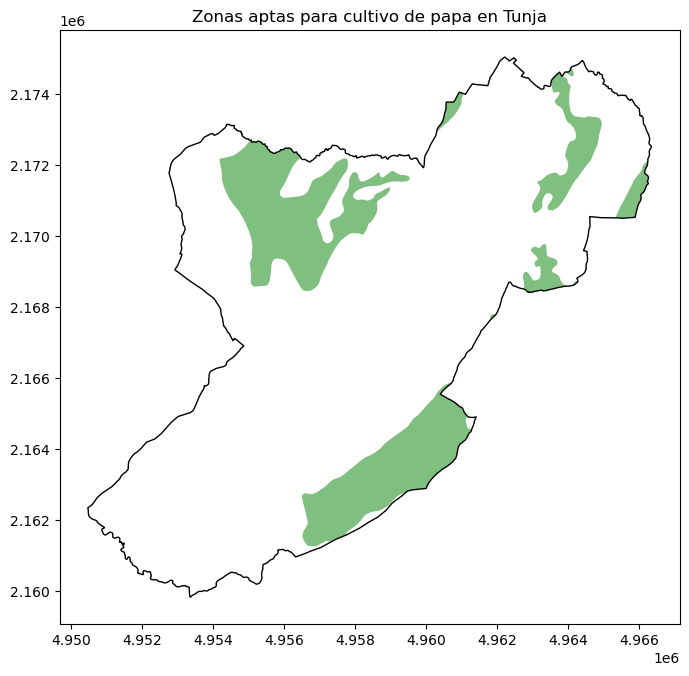

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
tunja.boundary.plot(ax=ax, color='black', linewidth=1)
papa_tunja_gdf.plot(ax=ax, color='green', alpha=0.5)
ax.set_title("Zonas aptas para cultivo de papa en Tunja")
plt.show()

Se define el mayor de centro de acopio en Tunja que se utilizará como criterio

In [33]:
mercado_1 = gpd.GeoDataFrame(
    {"nombre": ["Centro de acopio Tunja"]},
    geometry=[Point(-73.3723, 5.5087)],
    crs=4326
)
mercado = mercado_1.to_crs(9377)

Se visualiza la ubicación del centro de acopio en Tunja

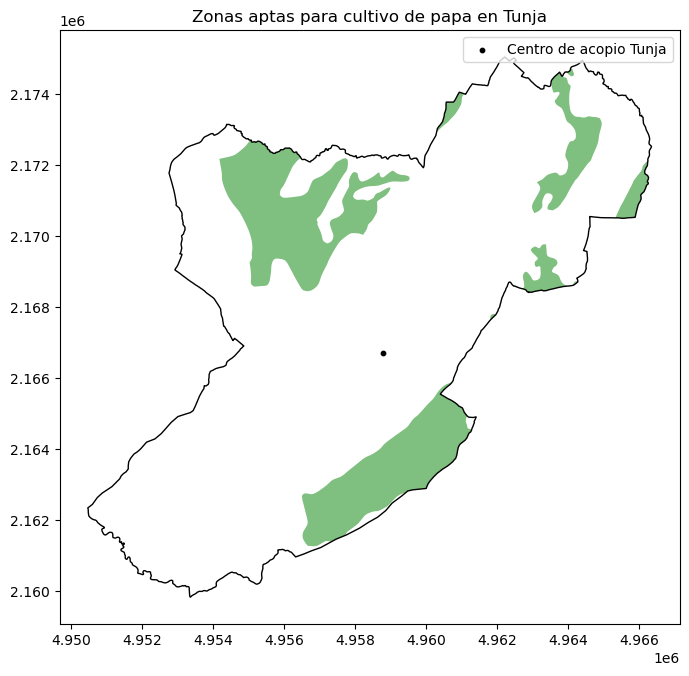

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
tunja.boundary.plot(ax=ax, color='black', linewidth=1)
papa_tunja_gdf.plot(ax=ax, color='green', alpha=0.5)
mercado.plot(ax=ax, color="black", markersize=10, label="Centro de acopio Tunja")
ax.set_title("Zonas aptas para cultivo de papa en Tunja")
ax.legend()
plt.show()

Se establecen los parámetros para construir la grilla partiendo de **papa_tunja_gdf**, por lo que los límites se toman de los límites de ese objeto. Cada celda tiene un área de 1km2

In [35]:
minx, miny, maxx, maxy = papa_tunja_gdf.total_bounds
celda = 1000
cols = list(range(int(minx), int(maxx), celda))
rows = list(range(int(miny), int(maxy), celda))
pols = [
    Point(x, y).buffer(celda / 2, cap_style=3).envelope
    for x in cols for y in rows
]

grid = gpd.GeoDataFrame(geometry=pols, crs=9377)
grid = grid[grid.intersects(papa_tunja_gdf.geometry.iloc[0])]

Se realiza la visualización de las grillas creadas de acuerdo a las zonas aptas para la producción de papa

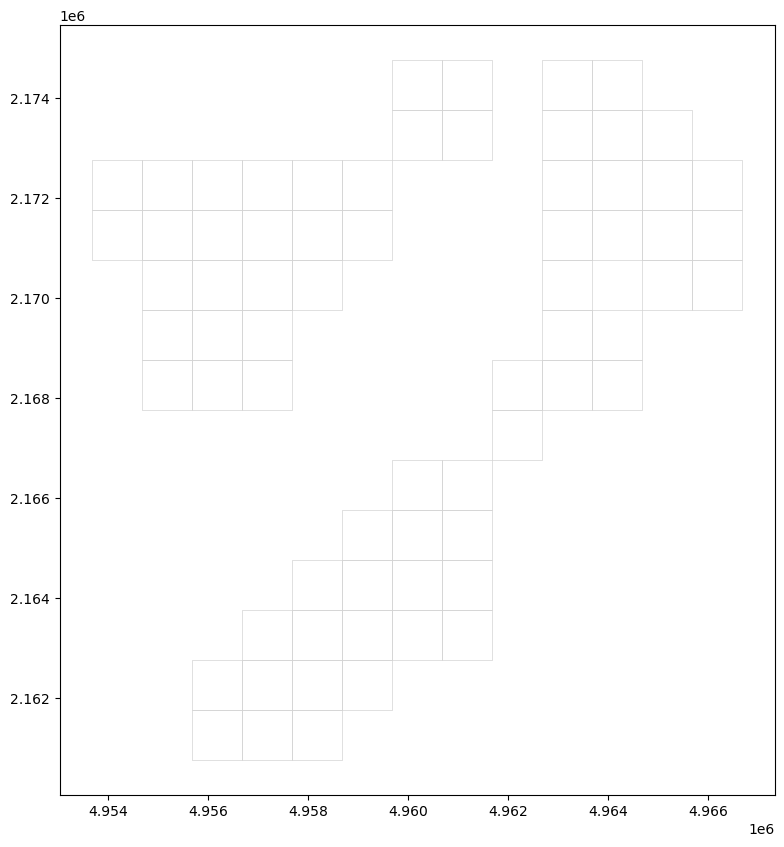

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
grid.boundary.plot(ax=ax, color='lightgray', linewidth=0.5)
plt.show()

Se definen las distancias de cada grilla partiendo del centroide a través de `.centroid.distance`

In [37]:
grid["dist_mercado"] = grid.centroid.distance(mercado.geometry.iloc[0])
grid["dist_vias"] = grid.centroid.distance(unary_union(vias_boy_muni.geometry))
grid["dist_est"] = grid.centroid.distance(unary_union(top20_estaciones.geometry))

Se realiza normalización de la distancia de cada grilla al centro de acopio, vías y estaciones para asignar el puntuaje y seleccionar la celda con mayor ponderación

In [38]:
grid["prox_mercado"] = 1 - (grid["dist_mercado"] - grid["dist_mercado"].min()) / (grid["dist_mercado"].max() - grid["dist_mercado"].min())
grid["prox_vias"] = 1 - (grid["dist_vias"] - grid["dist_vias"].min()) / (grid["dist_vias"].max() - grid["dist_vias"].min())
grid["prox_est"] = 1 - (grid["dist_est"] - grid["dist_est"].min()) / (grid["dist_est"].max() - grid["dist_est"].min())

grid["puntaje"] = (
    0.3 * grid["prox_vias"] +
    0.3 * grid["prox_est"] +
    0.4 * grid["prox_mercado"]
)
mejor_celda = grid.sort_values("puntaje", ascending=False).iloc[0]

Se realiza la intersección de las vías y estaciones. Para el caso de vías se realiza por medio de `.overlay`y para las estaciones por medio de `.sjoin`

In [39]:
vias_tunja = gpd.overlay(type1_road, tunja , how = 'intersection')
estac_tunja = gpd.sjoin(estac_gpd, tunja, how="inner", predicate="within")

Se realiza la visualización espacial de la celda resaltada en verde de acuerdo a los 4 criterios para la definición de la misma dentro de Tunja

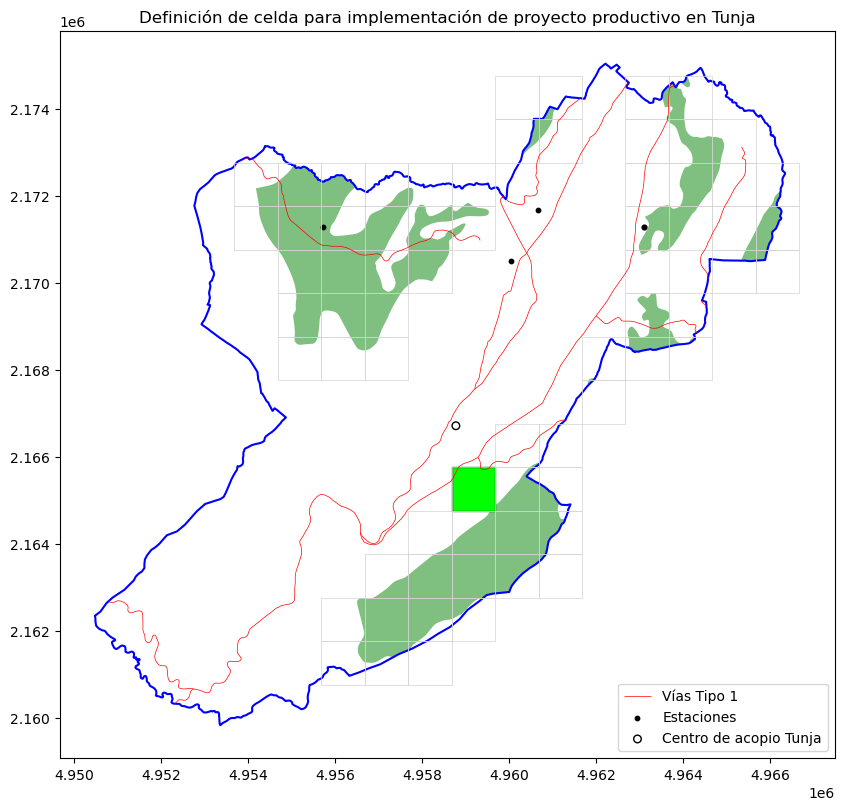

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
tunja.boundary.plot(ax=ax, color='blue', linewidth=1.5)
grid.boundary.plot(ax=ax, color='lightgray', linewidth=0.5)
papa_tunja_gdf.plot(ax=ax, color='green', alpha=0.5)
vias_tunja.plot(ax=ax, color='red', linewidth=0.5, label = "Vías Tipo 1")
estac_tunja.plot(ax=ax, color='black', markersize=10, label = "Estaciones")
mercado.plot(ax=ax, facecolor='none', edgecolor='black', markersize=30, label="Centro de acopio Tunja")
gpd.GeoSeries(mejor_celda.geometry).plot(ax=ax, color='lime', edgecolor='green')
plt.title("Definición de celda para implementación de proyecto productivo en Tunja")
ax.legend(loc='lower right')
plt.show()